# Load CoGo Status Stream files

In [460]:
%matplotlib inline

import matplotlib
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime
import math

import seaborn as sns
sns.set()

In [461]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [462]:
font = {'size'   : 50}
matplotlib.rc('font', **font)

LABEL_FONT_SIZE = 15
TITLE_FONT_SIZE = 25

## Import Data

In [463]:
def load_status_data(program_code = 'babs'):

    print('Loading %s Status Data...' % program_code.upper())

    try:
        file_path_slug = '../streamed_data/%s/*station_status*.csv' % program_code

        # glob all files
        file_list = glob(file_path_slug)

        status_import = pd.DataFrame()
        status_import_chunks = []

        counter = 1

        # load data from each file
        for file in file_list:

            chunksize = 10000

            # import file in chunks
            for chunk in pd.read_csv(file, chunksize=chunksize, iterator=True):

                # append chunk to chunks list
                status_import_chunks.append(chunk)

            if counter == 1 or counter % math.ceil(len(file_list)/10) == 0 or counter == len(file_list):
                print('\tFinished file! (%d of %d)' % (counter, len(file_list)))        

            counter += 1

        status_import = pd.concat(status_import_chunks)
        print('Data Loaded Successfully!\n')

    except:
        print('oops... something went wrong importing the data :(')

    
    status_import.rename(columns={'last_reported' : 'time', 
                                  'num_bikes_available' : 'bikes_available', 
                                  'num_bikes_disabled' : 'bikes_disabled', 
                                  'num_docks_available' : 'docks_available', 
                                  'num_docks_disabled' : 'docks_disabled'}, inplace=True)

    status_import['time'] = pd.to_datetime(status_import['time'], format="%Y-%m-%d %H:%M:%S")
    
    
    change_date = pd.Timestamp('2017-11-10')
    change_date = pd.Timestamp('2017-11-10 16:00')
    
    status_import = status_import[status_import.time >= change_date]




    status_import.sort_values('time', inplace=True)
    status_import.drop_duplicates(inplace=True)

    
    status_import['bike_change'] = status_import['bikes_available'].diff()
    status_import['bike_change'] = status_import['bike_change'].apply(lambda x: 1 if x > 0 else 0)
    
    status_import['dock_change'] = status_import['docks_available'].diff()
    status_import['dock_change'] = status_import['dock_change'].apply(lambda x: 1 if x > 0 else 0)
    

    
    status_import.reset_index(inplace=True, drop=True)
    status_import.head()
    
    return status_import

In [464]:
babs_status_data = load_status_data(program_code='babs')
cogo_status_data = load_status_data(program_code='cogo')

Loading BABS Status Data...
	Finished file! (1 of 477)
	Finished file! (48 of 477)
	Finished file! (96 of 477)
	Finished file! (144 of 477)
	Finished file! (192 of 477)
	Finished file! (240 of 477)
	Finished file! (288 of 477)
	Finished file! (336 of 477)
	Finished file! (384 of 477)
	Finished file! (432 of 477)
	Finished file! (477 of 477)
Data Loaded Successfully!

Loading COGO Status Data...
	Finished file! (1 of 478)
	Finished file! (48 of 478)
	Finished file! (96 of 478)
	Finished file! (144 of 478)
	Finished file! (192 of 478)
	Finished file! (240 of 478)
	Finished file! (288 of 478)
	Finished file! (336 of 478)
	Finished file! (384 of 478)
	Finished file! (432 of 478)
	Finished file! (478 of 478)
Data Loaded Successfully!



In [465]:
babs_status_data.groupby(babs_status_data.time.dt.date)['dock_change'].value_counts()

time        dock_change
2017-11-10  0              1417
            1              1250
2017-11-11  0              1836
            1              1669
Name: dock_change, dtype: int64

In [466]:
cogo_status_data.groupby(cogo_status_data.time.dt.date)['dock_change'].value_counts()

time        dock_change
2017-11-10  0              1848
            1              1555
2017-11-11  0              6386
            1              5002
Name: dock_change, dtype: int64

In [467]:
cogo_status_data.head(3)

,time,is_installed,is_renting,is_returning,bikes_available,bikes_disabled,docks_available,docks_disabled,station_id,bike_change,dock_change
0,2017-11-10 16:00:43,1,1,1,5,0,6,0,30,0,0
1,2017-11-10 17:46:35,1,1,1,5,0,10,0,53,0,1
2,2017-11-10 17:46:54,1,1,1,3,0,8,0,8,0,0


In [468]:
def show_station(df, id, x_label = '', y_label = '', title_suffix='', color='b', col='bikes_available'):
    t = df[df.station_id == id]
    t.set_index('time', inplace=True)
    ax = t[col].cumsum().plot(color=color, figsize=(24,3))
    if title_suffix != '':
        title = 'Station %s - %s' % (id, title_suffix)
    elif y_label != '':
        title = 'Station %s - %s' % (id, y_label)
    else:
        title = 'Station %s' % id
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
    ax.set_xlabel(x_label, size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel(y_label, size=LABEL_FONT_SIZE, weight='bold')
    plt.show()

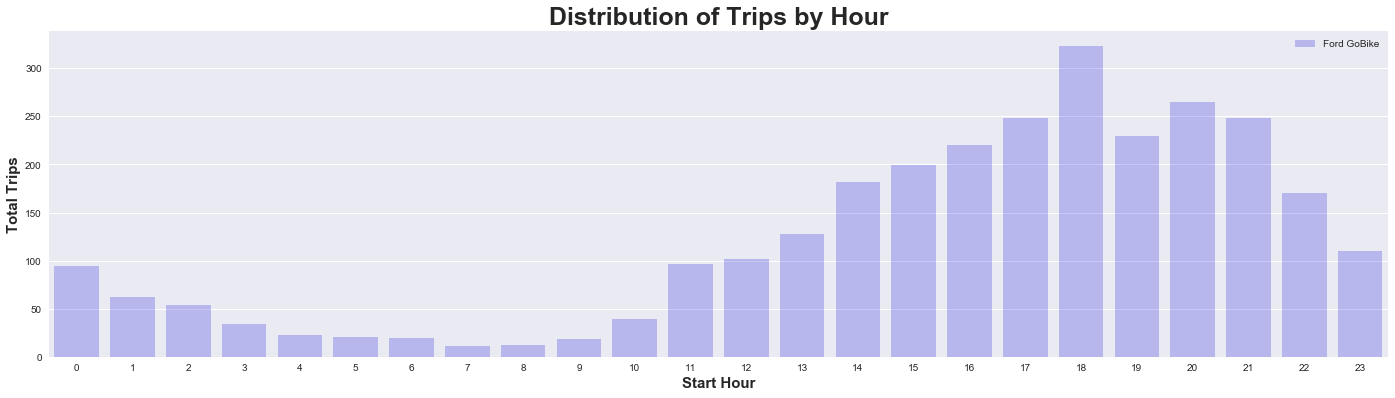

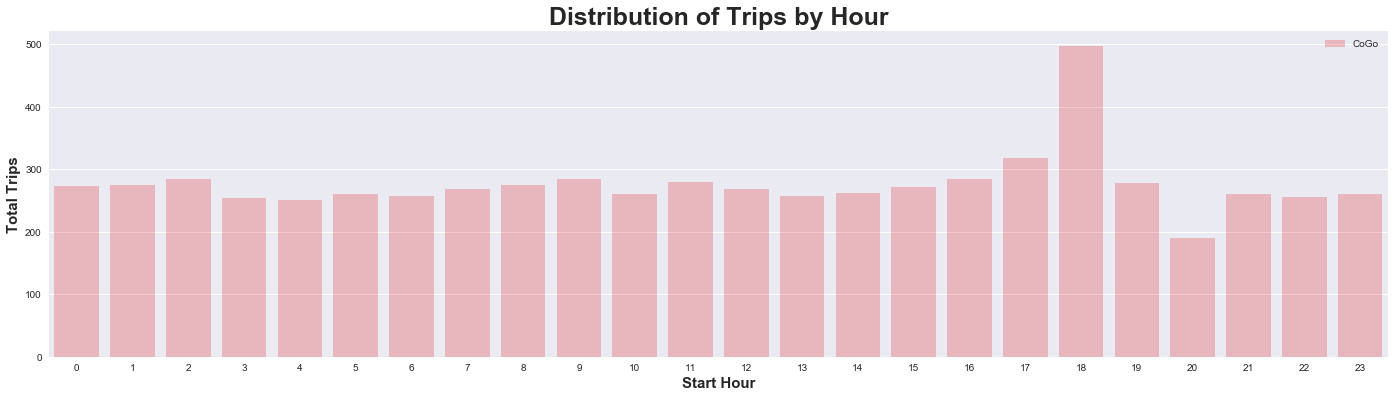

In [469]:
babs_x_ticks = sorted(pd.unique(babs_status_data.time.dt.hour))
cogo_x_ticks = sorted(pd.unique(cogo_status_data.time.dt.hour))

babs_data = babs_status_data[babs_status_data.bike_change != 0]
babs_data.reset_index(inplace=True, drop=True)

cogo_data = cogo_status_data[cogo_status_data.bike_change != 0]
cogo_data.reset_index(inplace=True, drop=True)

babs_status_change = babs_data.groupby([babs_data.time.dt.hour])['station_id'].count()
cogo_status_change = cogo_data.groupby([cogo_data.time.dt.hour])['station_id'].count()

plt.subplots(figsize=(24,6))
ax = sns.barplot(x = babs_status_change.index , y = babs_status_change, color='b', alpha = 0.25, label='Ford GoBike')
ax.set_title('Distribution of Trips by Hour', size=TITLE_FONT_SIZE, weight='bold')
ax.set_xlabel('Start Hour', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Total Trips', size=LABEL_FONT_SIZE, weight='bold')
ax.set_xticks(babs_x_ticks)
plt.legend()
plt.show()

plt.subplots(figsize=(24,6))
ax = sns.barplot(x = cogo_status_change.index , y = cogo_status_change, color='r', alpha = 0.25, label='CoGo')
ax.set_title('Distribution of Trips by Hour', size=TITLE_FONT_SIZE, weight='bold')
ax.set_xlabel('Start Hour', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Total Trips', size=LABEL_FONT_SIZE, weight='bold')
ax.set_xticks(cogo_x_ticks)
plt.legend()
plt.show()

In [470]:
print('[%s] Resampling on interval' % datetime.datetime.now().time())
babs_status_data_5m = babs_status_data.copy()
babs_status_data_5m.set_index(['station_id', 'time'], inplace=True)

# resample on 5 minute interval mean
babs_status_data_5m = babs_status_data_5m.groupby([pd.Grouper(level=0), pd.Grouper(freq='5T', level=-1)]).mean()
babs_status_data_5m.reset_index(inplace=True)

print('[%s] Complete' % datetime.datetime.now().time())

[16:09:24.363404] Resampling on interval
[16:09:24.416064] Complete


In [471]:
print('[%s] Resampling on interval' % datetime.datetime.now().time())
cogo_status_data_5m = cogo_status_data.copy()
cogo_status_data_5m.set_index(['station_id', 'time'], inplace=True)

# resample on 5 minute interval mean
cogo_status_data_5m = cogo_status_data_5m.groupby([pd.Grouper(level=0), pd.Grouper(freq='5T', level=-1)]).mean()
cogo_status_data_5m.reset_index(inplace=True)

print('[%s] Complete' % datetime.datetime.now().time())

[16:09:24.445017] Resampling on interval
[16:09:24.490636] Complete


In [472]:
print('Total cogo Trips:\t%s' % cogo_status_data.groupby('station_id').bike_change.sum().sum())
print('Total babs Trips:\t%s' % babs_status_data.groupby('station_id').bike_change.sum().sum())

Total cogo Trips:	6629
Total babs Trips:	2910


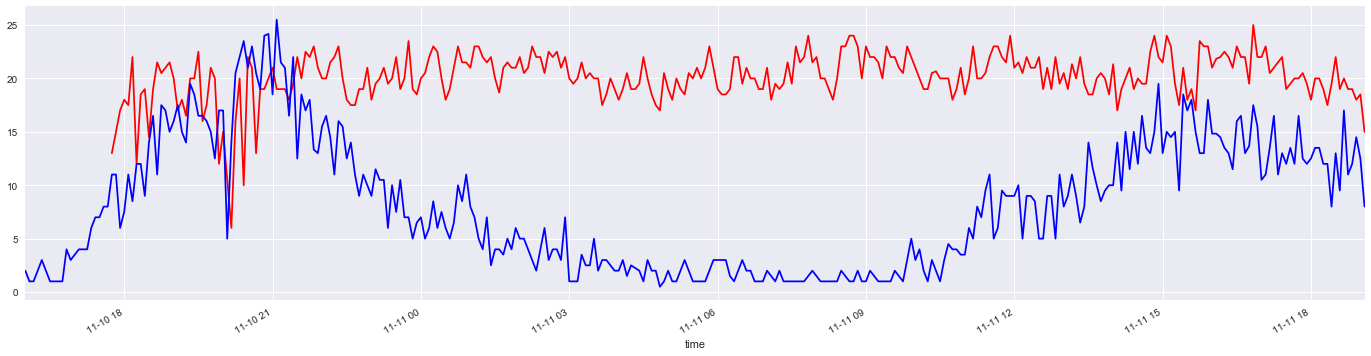

In [473]:
ax = cogo_status_data_5m[cogo_status_data_5m.bike_change > 0].groupby('time').bike_change.sum().plot(color='r', figsize=(24,6))
babs_status_data_5m[babs_status_data_5m.bike_change > 0].groupby('time').bike_change.sum().plot(color='b', ax=ax)
plt.show()

In [474]:
for i in sorted(pd.unique(cogo_status_data.station_id)):
    print('Total CoGo Trips from Station %s:\t%s' % (i, cogo_status_data[cogo_status_data.station_id == i].bike_change.sum().sum()))

Total CoGo Trips from Station 1:	296
Total CoGo Trips from Station 2:	54
Total CoGo Trips from Station 3:	133
Total CoGo Trips from Station 4:	239
Total CoGo Trips from Station 5:	177
Total CoGo Trips from Station 6:	194
Total CoGo Trips from Station 7:	199
Total CoGo Trips from Station 8:	25
Total CoGo Trips from Station 9:	246
Total CoGo Trips from Station 10:	276
Total CoGo Trips from Station 11:	2
Total CoGo Trips from Station 12:	273
Total CoGo Trips from Station 13:	72
Total CoGo Trips from Station 14:	92
Total CoGo Trips from Station 15:	186
Total CoGo Trips from Station 16:	83
Total CoGo Trips from Station 17:	3
Total CoGo Trips from Station 18:	70
Total CoGo Trips from Station 19:	237
Total CoGo Trips from Station 20:	185
Total CoGo Trips from Station 21:	168
Total CoGo Trips from Station 22:	196
Total CoGo Trips from Station 23:	280
Total CoGo Trips from Station 24:	296
Total CoGo Trips from Station 25:	5
Total CoGo Trips from Station 26:	196
Total CoGo Trips from Station 27:

In [475]:
cogo_status_data.groupby('station_id').bike_change.sum().to_frame().sort_values('bike_change', ascending=False)

,bike_change
station_id,
1,296
24,296
59,282
23,280
10,276
52,275
12,273
60,271
51,259
